**remark**
trying to create a file which can be used to calculate the CIPW norm beginning from an excell file (used the infile previously

In [51]:
import numpy as np
import pandas as pd

In [52]:
import prepostprocessing.cleaning as cleaning
import prepostprocessing.pre_processing as preproc
from qapf import qapf
from qapf import cipw

___

## Test - convert to CIPWFULL format

**I used an arbitrary version of the mineralogical data, not sure if this is the correct one** -->is a good one

In [60]:
mineralogy_original = pd.read_excel("../_PETRO/classification_altereddata.xlsx", index_col=0)
# Only iterested in sample number and oxides
mineralogy = mineralogy_original[['SiO2', 'TiO2', 'Al2O3', 'Fe2O3','FeO', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'P2O5', 'l.i.', 'oth']]
mineralogy.columns

Index(['SiO2', 'TiO2', 'Al2O3', 'Fe2O3', 'FeO', 'MnO', 'MgO', 'CaO', 'Na2O',
       'K2O', 'P2O5', 'l.i.', 'oth'],
      dtype='object')

In [61]:
# Check for closed sum
assert all(np.isclose(mineralogy.sum(axis=1), 100.0))

In [62]:
# Remove 'l.i.'' and 'oth' columns and immediately normalize data
mineralogy = preproc.normalize(mineralogy.drop(["l.i.", "oth"], axis=1))

In [63]:
# Check for closed sum
assert all(np.isclose(mineralogy.sum(axis=1), 100.0))

In [64]:
mineralogy.head()

,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5
1,80.888978,0.040044,10.171188,0.610672,1.721894,0.010011,0.400440,0.550606,2.002202,3.593953,0.010011
2,80.685830,0.100857,10.186586,0.171457,0.564801,0.020171,0.403429,0.353001,2.319718,5.143722,0.050429
3,80.776228,0.050536,9.995957,0.161714,1.748534,0.020214,0.121286,0.141500,0.758035,6.215888,0.010107
4,79.316869,0.039833,9.599681,1.145190,0.746863,0.099582,0.448118,0.667198,3.694483,4.232225,0.009958
5,80.231026,0.081062,10.375925,0.648495,2.634512,0.040531,0.050664,1.266592,1.540176,3.120884,0.010133


In [65]:
cipw.convert_to_CIPWFULL_format(mineralogy, "../_CIPW/test.txt", dataset_name="Vistelius (1995)")

_____

## Test - extract results from CIPWFULL results file

**I only selected quartz, plagioclase and alkali feldspar here as they are of interest to us for the QAPF classification**  
**Feel free to extract addiotnal minerals if they would be of any interest to you**

**Not sure what to do with albite in the final assignments as by the book it should be accounted for as an alkali feldspar and thus be included in the sum of plagioclase but then the resulting plagioclase contents seem quite low.   
This is something you might look into although the method used here seems to be correct according to te resulting QAPF diagram.**

In [66]:
df_final = cipw.extract_CIPW_results("../_CIPW/test_excel.txt")

In [67]:
df_final

,Q,P,K
SAMPLE,,,
1,52.549507,19.606903,21.237118
2,45.940433,21.049126,30.394911
3,50.739986,7.049767,36.730503
4,41.407116,25.813734,25.008740
5,54.633030,19.248727,18.441685
...,...,...,...
4655,0.000000,64.289797,12.030162
4656,0.185825,54.481821,9.744569
4657,0.497182,53.845592,13.390444


## Test - QAPF classification

In [68]:
df_final["QAPF"] = qapf.check_QAPF_region(df_final)

In [69]:
df_final["QAPF"].unique()

array(['monzo granite', 'syeno granite', 'quartz-rich granitoid',
       'granodiorite', 'tonalite',
       'quartz monzodiorite\nquartz monzogabbro', 'quartz monzonite',
       'monzonite', 'quartz diorite\nquartz gabbro\nquartz anorthosite',
       'monzodiorite monzogabbro', 'diorite gabbro anorthosite'],
      dtype=object)

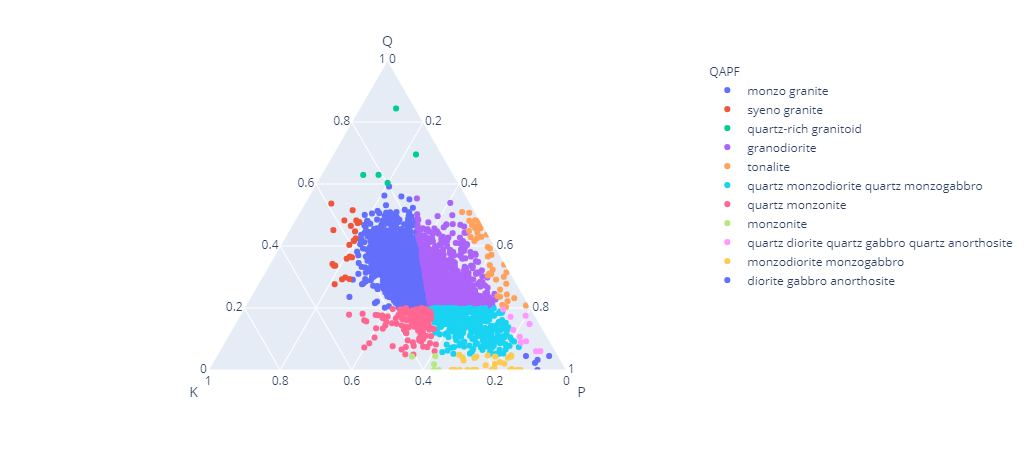

In [70]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter_ternary(df_final, a="Q", b="K", c="P", color="QAPF")

fig.write_image(f"../_FIGURES/qapf_ternary/qapf_ternary_all.pdf")
fig.show()

In [160]:
df_final.to_excel("../_CIPW/QAPF.xlsx", index=True)

## Check alkalinity

**Remark**
wanted to check if both calculations delivered the same results--> there are some differences

In [104]:
check_alkalinity = pd.read_excel("../_CIPW/test_excel.xlsx", index=1, usecols=[20])

In [105]:
check_alkalinity

,ALKALINITY
0,PERALUMINOUS
1,PERALUMINOUS
2,PERALUMINOUS
3,PERALKALINE
4,PERALUMINOUS
...,...
4655,METALUMINOUS
4656,METALUMINOUS
4657,METALUMINOUS
4658,METALUMINOUS


In [92]:
check_alkalinity.iloc[:, 0].value_counts().to_excel("../_PETRO/ASI_counts_CIPW.xlsx")

-----

## creating data to plot QAPF in Qgis

In [169]:
QAPF_plot = pd.read_excel("../_PETRO/classification_altereddata.xlsx", index_col=0, usecols=[0, 5, 6])
QAPF = pd.read_excel("../_CIPW/QAPF.xlsx", index_col=0)

In [170]:
QAPF

,Q,P,K,QAPF
SAMPLE,,,,
1,52.549507,19.606903,21.237118,monzo granite
2,45.940433,21.049126,30.394911,monzo granite
3,50.739986,7.049767,36.730503,syeno granite
4,41.407116,25.813734,25.008740,monzo granite
5,54.633030,19.248727,18.441685,monzo granite
...,...,...,...,...
4655,0.000000,64.289797,12.030162,monzodiorite monzogabbro
4656,0.185825,54.481821,9.744569,monzodiorite monzogabbro
4657,0.497182,53.845593,13.390444,monzodiorite monzogabbro


In [171]:
QAPF_plot.insert(2, "QAPF", QAPF['QAPF']) 

In [172]:
QAPF_plot

,Latitude,Longitude,QAPF
1,"44°31'30.0""","138°37'30.0""",monzo granite
2,"54°12'10.0""","119°24'0.0""",monzo granite
3,"62°36'0.0""","155°36'0.0""",syeno granite
4,"61°35'0.0""","146°2'0.0""",monzo granite
5,"68°55'0.0""","164°24'0.0""",monzo granite
...,...,...,...
4655,"66°42'0.0""","164°23'0.0""",monzodiorite monzogabbro
4656,"46°56'30.0""","137°5'3.0""",monzodiorite monzogabbro
4657,"58°12'0.0""","138°12'0.0""",monzodiorite monzogabbro
4658,"60°51'0.0""","147°31'0.0""",diorite gabbro anorthosite


In [173]:
QAPF_plot.to_excel("../_CIPW/QAPF_plot.xlsx", index=True)

In [175]:
QAPF_plot.iloc[:, 2].value_counts().to_excel("../_CIPW/QAPF_count.xlsx")

------